In [6]:
import geopandas as gpd
from geocube.api.core import make_geocube
import pystac_client
import stackstac
import matplotlib.pyplot as plt
import planetary_computer
import xarray as xr
import numpy as np
import rioxarray

In [2]:
aoi = gpd.read_file('../../2_data/Koumbia_db/Koumbia_JECAM_2018-20-21.shp')
aoi_4326 = aoi.to_crs('EPSG: 4326')
bbox = aoi_4326.total_bounds
bands = ['B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B11', 'B12']
year = '2018'
time = year + '-01-01/' + year + '-12-31'

In [3]:
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
    )

In [4]:
s2_search_all = catalog.search(
        collections=["sentinel-2-l2a"],
        bbox= bbox,
        datetime= time,
        query={'eo:cloud_cover': {"lt": 100}, 
                's2:nodata_pixel_percentage': {'lt': 50},
                's2:mgrs_tile': {'eq': '30PVT'}},
        )
complete_item = s2_search_all.item_collection()
petite_bbox = [415000, 1240000, 415000+1000, 1240000+1000]
stack = stackstac.stack(complete_item, resolution = 10, bounds = petite_bbox, chunksize= (69, 1, 100, 100))
SCL = stack.sel(band = 'SCL')

cirrus = xr.where(SCL == 10, 1, 0) # cirrus pixels, binary mask 0, 1
highclouds = xr.where(SCL == 9, 1, 0) # High probability clouds, binary mask 0, 1
medclouds = xr.where(SCL == 8, 1, 0) # Medium probability clouds, binary mask 0, 1
unclass = xr.where(SCL == 7, 1, 0) # unclassified pixels, binary mask 0, 1
shaclouds = xr.where(SCL == 3, 1, 0) # Cloud shadows, binary mask 0, 1
saturated = xr.where(SCL == 1, 1, 0) # saturated pixels, binary mask 0, 1

## mannually check quality of final interpolation

mask = highclouds + medclouds + shaclouds + saturated + cirrus + unclass # Mask, binary mask 0, 1
maskedstack = stack.where(mask == 0, np.nan)
interpolate_stack = maskedstack.interpolate_na(dim="time", method="linear", use_coordinate = 'time')

/Users/edgar/opt/anaconda3/envs/GeoDS/lib/python3.11/site-packages/stackstac/accumulate_metadata.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array(


In [8]:
interpolate_stack.shape

(69, 17, 100, 100)

In [11]:
interpolate_stack[0, 1, :, :].rio.to_raster("test.tif")

In [87]:
minmax_bandtime = interpolate_stack.quantile([0.02, 0.98], dim=['x', 'y'])

In [88]:
minmax_bandtime

<xarray.DataArray 'stackstac-98db58911142a7f6de2930221c2cb9cf' (quantile: 2,
                                                                time: 69,
                                                                band: 17)>
dask.array<transpose, shape=(2, 69, 17), dtype=float64, chunksize=(2, 69, 1), chunktype=numpy.ndarray>
Coordinates: (12/24)
  * time                               (time) datetime64[ns] 2018-01-05T10:34...
    id                                 (time) <U54 'S2A_MSIL2A_20180105T10342...
  * band                               (band) <U7 'AOT' 'B01' ... 'preview'
    s2:product_uri                     (time) <U65 'S2A_MSIL2A_20180105T10342...
    s2:high_proba_clouds_percentage    (time) float64 0.000418 7.553 ... 2.122
    s2:unclassified_percentage         (time) float64 0.1308 0.4205 ... 0.5202
    ...                                 ...
    s2:cloud_shadow_percentage         (time) float64 0.0 0.000564 ... 0.04193
    s2:mean_solar_azimuth              (time) float64 146.6 145.4 ... 147.8
    s2:nodata_pixel_percentage         (time) float64 0.0 0.0 0.0 ... 0.0 0.0
    platform                           (time) <U11 'Sentinel-2A' ... 'Sentine...
    s2:water_percentage                (time) float64 0.06624 ... 0.06542
  * quantile                           (quantile) float64 0.02 0.98

In [93]:
norm_stack = (interpolate_stack - minmax_bandtime[0, :, :]) / (minmax_bandtime[1, :, :] - minmax_bandtime[0, :, :])

In [97]:
interpolate_stack

<xarray.DataArray 'stackstac-98db58911142a7f6de2930221c2cb9cf' (time: 69,
                                                                band: 17,
                                                                y: 100, x: 100)>
dask.array<transpose, shape=(69, 17, 100, 100), dtype=float64, chunksize=(69, 1, 100, 100), chunktype=numpy.ndarray>
Coordinates: (12/38)
  * time                                     (time) datetime64[ns] 2018-01-05...
    id                                       (time) <U54 'S2A_MSIL2A_20180105...
  * band                                     (band) <U7 'AOT' ... 'preview'
  * x                                        (x) float64 4.15e+05 ... 4.16e+05
  * y                                        (y) float64 1.241e+06 ... 1.24e+06
    s2:product_uri                           (time) <U65 'S2A_MSIL2A_20180105...
    ...                                       ...
    s2:nodata_pixel_percentage               (time) float64 0.0 0.0 ... 0.0 0.0
    platform                                 (time) <U11 'Sentinel-2A' ... 'S...
    s2:water_percentage                      (time) float64 0.06624 ... 0.06542
    s2:snow_ice_percentage                   float64 0.0
    s2:saturated_defective_pixel_percentage  float64 0.0
    epsg                                     int64 32630
Attributes:
    spec:        RasterSpec(epsg=32630, bounds=(415000, 1240000, 416000, 1241...
    crs:         epsg:32630
    transform:   | 10.00, 0.00, 415000.00|\n| 0.00,-10.00, 1241000.00|\n| 0.0...
    resolution:  10

In [94]:
norm_stack

<xarray.DataArray 'stackstac-98db58911142a7f6de2930221c2cb9cf' (time: 69,
                                                                band: 17,
                                                                y: 100, x: 100)>
dask.array<truediv, shape=(69, 17, 100, 100), dtype=float64, chunksize=(69, 1, 100, 100), chunktype=numpy.ndarray>
Coordinates: (12/39)
  * time                                     (time) datetime64[ns] 2018-01-05...
    id                                       (time) <U54 'S2A_MSIL2A_20180105...
  * band                                     (band) <U7 'AOT' ... 'preview'
  * x                                        (x) float64 4.15e+05 ... 4.16e+05
  * y                                        (y) float64 1.241e+06 ... 1.24e+06
    s2:product_uri                           (time) <U65 'S2A_MSIL2A_20180105...
    ...                                       ...
    platform                                 (time) <U11 'Sentinel-2A' ... 'S...
    s2:water_percentage                      (time) float64 0.06624 ... 0.06542
    s2:snow_ice_percentage                   float64 0.0
    s2:saturated_defective_pixel_percentage  float64 0.0
    epsg                                     int64 32630
    quantile                                 float64 0.02

In [102]:
norm_stack._copy_attrs_from(interpolate_stack)

In [104]:
norm_stack

<xarray.DataArray 'stackstac-98db58911142a7f6de2930221c2cb9cf' (time: 69,
                                                                band: 17,
                                                                y: 100, x: 100)>
dask.array<truediv, shape=(69, 17, 100, 100), dtype=float64, chunksize=(69, 1, 100, 100), chunktype=numpy.ndarray>
Coordinates: (12/39)
  * time                                     (time) datetime64[ns] 2018-01-05...
    id                                       (time) <U54 'S2A_MSIL2A_20180105...
  * band                                     (band) <U7 'AOT' ... 'preview'
  * x                                        (x) float64 4.15e+05 ... 4.16e+05
  * y                                        (y) float64 1.241e+06 ... 1.24e+06
    s2:product_uri                           (time) <U65 'S2A_MSIL2A_20180105...
    ...                                       ...
    platform                                 (time) <U11 'Sentinel-2A' ... 'S...
    s2:water_percentage                      (time) float64 0.06624 ... 0.06542
    s2:snow_ice_percentage                   float64 0.0
    s2:saturated_defective_pixel_percentage  float64 0.0
    epsg                                     int64 32630
    quantile                                 float64 0.02
Attributes:
    spec:        RasterSpec(epsg=32630, bounds=(415000, 1240000, 416000, 1241...
    crs:         epsg:32630
    transform:   | 10.00, 0.00, 415000.00|\n| 0.00,-10.00, 1241000.00|\n| 0.0...
    resolution:  10

In [39]:
aoi_raster = make_geocube(
    vector_data=aoi,
    output_crs="epsg:32630",
    resolution=(10, 10)
)

(415000.0, 416000.0)

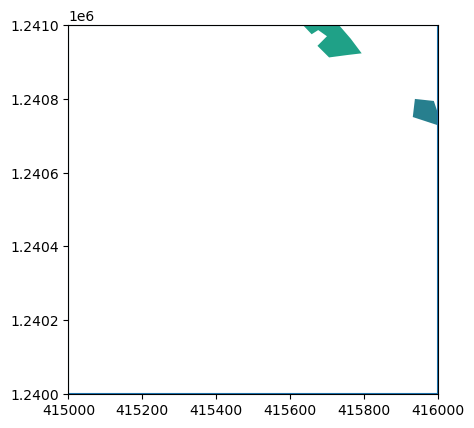

In [42]:
aoi.plot(column='CodeL2')
plt.axvline(petite_bbox[0])
plt.axvline(petite_bbox[2])
plt.axhline(petite_bbox[1])
plt.axhline(petite_bbox[3])

plt.ylim(petite_bbox[1], petite_bbox[3])
plt.xlim(petite_bbox[0], petite_bbox[2])


In [40]:
cropped_aoi = aoi_raster.sel(x=slice(petite_bbox[0],petite_bbox[2]), y=slice(petite_bbox[1],petite_bbox[3]))

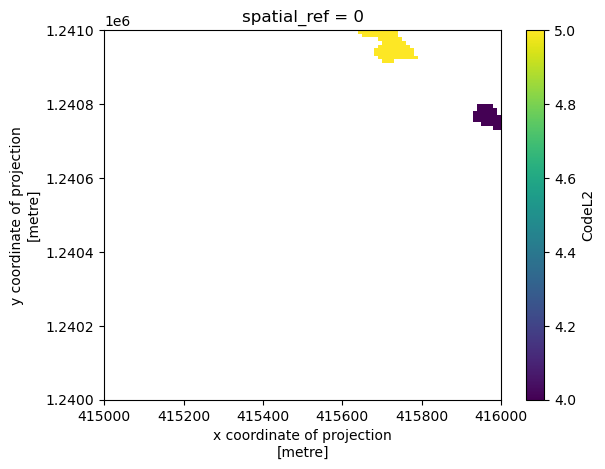

In [41]:
cropped_aoi['CodeL2'].plot()

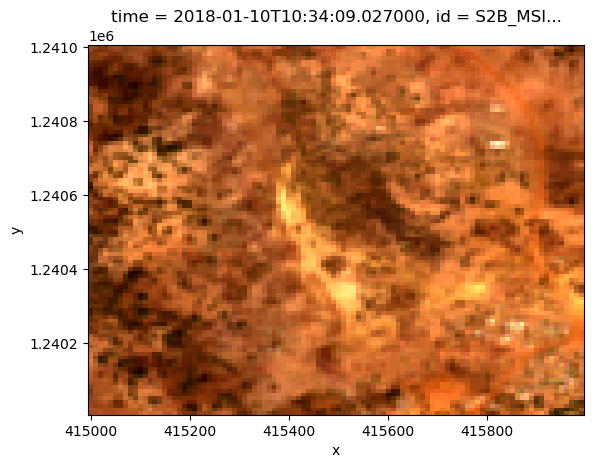

In [96]:
interpolate_stack[1, :, :, :].sel(band = ['B04', 'B03', 'B02']).plot.imshow(rgb="band", robust=True)

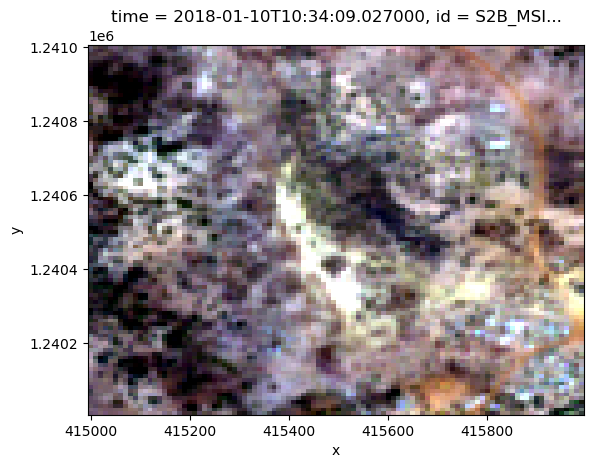

In [95]:
norm_stack[1, :, :, :].sel(band = ['B04', 'B03', 'B02']).plot.imshow(rgb="band", robust=True)

In [105]:
clipped = norm_stack.rio.clip(aoi.geometry, norm_stack.rio.crs)

In [106]:
clipped

<xarray.DataArray 'stackstac-98db58911142a7f6de2930221c2cb9cf' (time: 69,
                                                                band: 17,
                                                                y: 27, x: 36)>
dask.array<getitem, shape=(69, 17, 27, 36), dtype=float64, chunksize=(69, 1, 27, 36), chunktype=numpy.ndarray>
Coordinates: (12/40)
  * time                                     (time) datetime64[ns] 2018-01-05...
    id                                       (time) <U54 'S2A_MSIL2A_20180105...
  * band                                     (band) <U7 'AOT' ... 'preview'
  * x                                        (x) float64 4.156e+05 ... 4.16e+05
  * y                                        (y) float64 1.241e+06 ... 1.241e+06
    s2:product_uri                           (time) <U65 'S2A_MSIL2A_20180105...
    ...                                       ...
    s2:water_percentage                      (time) float64 0.06624 ... 0.06542
    s2:snow_ice_percentage                   float64 0.0
    s2:saturated_defective_pixel_percentage  float64 0.0
    epsg                                     int64 32630
    quantile                                 float64 0.02
    spatial_ref                              int64 0
Attributes:
    spec:        RasterSpec(epsg=32630, bounds=(415000, 1240000, 416000, 1241...
    resolution:  10

In [107]:
clipped[1, :, :, :].sel(band = ['B04', 'B03', 'B02']).plot.imshow(rgb="band", robust=True)

KeyboardInterrupt: 

In [72]:
clipped

<xarray.DataArray 'stackstac-003e8985de917a80a5ad621cf7569bde' (time: 69,
                                                                band: 17,
                                                                y: 27, x: 36)>
dask.array<getitem, shape=(69, 17, 27, 36), dtype=float64, chunksize=(69, 1, 27, 36), chunktype=numpy.ndarray>
Coordinates: (12/39)
  * time                                     (time) datetime64[ns] 2018-01-05...
    id                                       (time) <U54 'S2A_MSIL2A_20180105...
  * band                                     (band) <U7 'AOT' ... 'preview'
  * x                                        (x) float64 4.156e+05 ... 4.16e+05
  * y                                        (y) float64 1.241e+06 ... 1.241e+06
    s2:product_uri                           (time) <U65 'S2A_MSIL2A_20180105...
    ...                                       ...
    platform                                 (time) <U11 'Sentinel-2A' ... 'S...
    s2:water_percentage                      (time) float64 0.06624 ... 0.06542
    s2:snow_ice_percentage                   float64 0.0
    s2:saturated_defective_pixel_percentage  float64 0.0
    epsg                                     int64 32630
    spatial_ref                              int64 0
Attributes:
    spec:        RasterSpec(epsg=32630, bounds=(415000, 1240000, 416000, 1241...
    resolution:  10

In [78]:
df = clipped[:, 1, :, :].to_dataframe()
df

id  \
time                    y         x                                                             
2018-01-05 10:34:21.026 1241000.0 415640.0  S2A_MSIL2A_20180105T103421_R108_T30PVT_2020101...   
                                  415650.0  S2A_MSIL2A_20180105T103421_R108_T30PVT_2020101...   
                                  415660.0  S2A_MSIL2A_20180105T103421_R108_T30PVT_2020101...   
                                  415670.0  S2A_MSIL2A_20180105T103421_R108_T30PVT_2020101...   
                                  415680.0  S2A_MSIL2A_20180105T103421_R108_T30PVT_2020101...   
...                                                                                       ...   
2018-12-31 10:34:31.025 1240740.0 415950.0  S2A_MSIL2A_20181231T103431_R108_T30PVT_2020100...   
                                  415960.0  S2A_MSIL2A_20181231T103431_R108_T30PVT_2020100...   
                                  415970.0  S2A_MSIL2A_20181231T103431_R108_T30PVT_2020100...   
                                  415980.0  S2A_MSIL2A_20181231T103431_R108_T30PVT_2020100...   
                                  415990.0  S2A_MSIL2A_20181231T103431_R108_T30PVT_2020100...   

                                           band  \
time                    y         x               
2018-01-05 10:34:21.026 1241000.0 415640.0  B01   
                                  415650.0  B01   
                                  415660.0  B01   
                                  415670.0  B01   
                                  415680.0  B01   
...                                         ...   
2018-12-31 10:34:31.025 1240740.0 415950.0  B01   
                                  415960.0  B01   
                                  415970.0  B01   
                                  415980.0  B01   
                                  415990.0  B01   

                                                                               s2:product_uri  \
time                    y         x                                                             
2018-01-05 10:34:21.026 1241000.0 415640.0  S2A_MSIL2A_20180105T103421_N0212_R108_T30PVT_2...   
                                  415650.0  S2A_MSIL2A_20180105T103421_N0212_R108_T30PVT_2...   
                                  415660.0  S2A_MSIL2A_20180105T103421_N0212_R108_T30PVT_2...   
                                  415670.0  S2A_MSIL2A_20180105T103421_N0212_R108_T30PVT_2...   
                                  415680.0  S2A_MSIL2A_20180105T103421_N0212_R108_T30PVT_2...   
...                                                                                       ...   
2018-12-31 10:34:31.025 1240740.0 415950.0  S2A_MSIL2A_20181231T103431_N0212_R108_T30PVT_2...   
                                  415960.0  S2A_MSIL2A_20181231T103431_N0212_R108_T30PVT_2...   
                                  415970.0  S2A_MSIL2A_20181231T103431_N0212_R108_T30PVT_2...   
                                  415980.0  S2A_MSIL2A_20181231T103431_N0212_R108_T30PVT_2...   
                                  415990.0  S2A_MSIL2A_20181231T103431_N0212_R108_T30PVT_2...   

                                            s2:degraded_msi_data_percentage  \
time                    y         x                                           
2018-01-05 10:34:21.026 1241000.0 415640.0                              0.0   
                                  415650.0                              0.0   
                                  415660.0                              0.0   
                                  415670.0                              0.0   
                                  415680.0                              0.0   
...                                                                     ...   
2018-12-31 10:34:31.025 1240740.0 415950.0                              0.0   
                                  415960.0                              0.0   
                                  415970.0                              0.0   
                                  